In [21]:
# 和CPDT论文对比F1-score

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gzip, base64

In [2]:
device = 'cpu'

In [3]:
# 设置环境变量避免警告
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [5]:
# 设置matplotlib使用math text
plt.rcParams['axes.formatter.use_mathtext'] = True
# 如果需要更完整的数学字体设置，可以添加：
plt.rcParams['mathtext.fontset'] = 'cm'  # 使用Computer Modern字体
plt.rcParams['font.family'] = 'STIXGeneral'  # 使用STIX字体族

In [52]:
def lsh_compress(vector, random_projections):
    """将向量压缩为256位整数"""
    projections = np.dot(vector, random_projections.T)
    binary = (projections > 0).astype(int)
    compressed = 0
    for i, bit in enumerate(binary):
        if bit:
            compressed |= (1 << i)
    return compressed

def hamming_similarity(a, b):
    """计算两个压缩向量的相似度"""
    xor = a ^ b
    hamming_distance = bin(xor).count('1')
    return (256 - hamming_distance) / 256.0

def uint256_to_bits256(u):
    """uint256 → list[int] 长度 256"""
    return [(u >> i) & 1 for i in range(256)]

def mse256(a, b):
    """a, b: uint256 → MSE ∈ [0, 256]"""
    bits_a = uint256_to_bits256(a)
    bits_b = uint256_to_bits256(b)
    return sum((x - y) ** 2 for x, y in zip(bits_a, bits_b))

def mse_similarity(a, b):
    return 1.0 - mse256(a, b) / 256.0   # 0=完全不同, 1=完全相同

def calc_lsh_sim(lsh_list):
    original = lsh_list[0]
    # hamming_similarity和mse_similarity结果差不多
    similarities = [hamming_similarity(original, v) for v in lsh_list[1:]]
    # similarities = [mse_similarity(original, v) for v in lsh_list[1:]]
    return similarities

def f1_fp_fn_curves(similars, dissimilars, thresh_range=np.linspace(0, 1, 101)):
    f1s, fps, fns = [], [], []
    n_pos, n_neg = len(similars), len(dissimilars)
    for t in thresh_range:
        TP = (similars >= t).sum()
        FN = (similars < t).sum()
        FP = (dissimilars >= t).sum()
        TN = (dissimilars < t).sum()

        prec = TP / (TP + FP + 1e-12)
        rec  = TP / (TP + FN + 1e-12)
        f1   = 2 * prec * rec / (prec + rec + 1e-12)

        f1s.append(f1)
        fps.append(FP / n_neg)   # FP 率 = FP / 总负样本
        fns.append(FN / n_pos)   # FN 率 = FN / 总正样本

    return thresh_range, np.array(f1s), np.array(fps), np.array(fns)

# 图像（COCO数据集）

## DINOv2

In [17]:
df = pd.read_parquet('./coco_1k_67k/meta_dino_v2.parquet')

In [21]:
df['fid'] = df.file.apply(lambda x: x[:6])

In [22]:
df.shape

(68000, 6)

In [26]:
dim = len(df.feature.loc[0])
np.random.seed(42)
n_projections = 256
random_projections = np.random.randn(n_projections, dim)
df['lsh'] = df.feature.apply(lambda x: lsh_compress(x, random_projections))

In [27]:
df_g = df.dropna(subset=['feature']).groupby('fid')['lsh'].apply(list).reset_index(name='lsh_sim_list')

In [28]:
a = df_g['lsh_sim_list'].str[0]          # 所有首元素
df_g['lsh_dissim_list'] = [
    [x] + a[~a.isin([x])].sample(67, random_state=42).tolist()
    for x in a
]             # 随机选择其它67个首元素

In [29]:
df_g['similars'] = df_g.lsh_sim_list.apply(calc_lsh_sim)

In [30]:
df_g['dissimilars'] = df_g.lsh_dissim_list.apply(calc_lsh_sim)

In [31]:
similars_dino_v2 = np.array(sum(df_g.similars.values.tolist(), []))
dissimilars_dino_v2 = np.array(sum(df_g.dissimilars.values.tolist(), []))

In [32]:
similars_dino_v2.shape, dissimilars_dino_v2.shape

((67000,), (67000,))

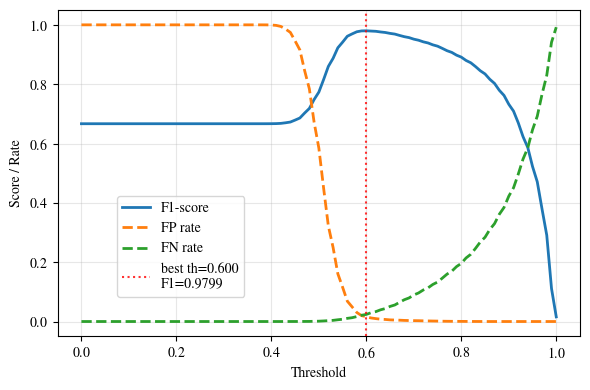

In [37]:
# 计算三条曲线
threshs, f1s, fps, fns = f1_fp_fn_curves(similars_dino_v2, dissimilars_dino_v2)

# 最佳 F1 点
best_idx = f1s.argmax()
best_t   = threshs[best_idx]

# 画图
plt.figure(figsize=(6, 4))
plt.plot(threshs, f1s, label='F1-score', lw=2)
plt.plot(threshs, fps, label='FP rate', lw=2, ls='--')
plt.plot(threshs, fns, label='FN rate', lw=2, ls='--')

# 最佳 F1 竖线
plt.axvline(x=best_t, color='r', ls=':', alpha=0.8,
            label=f'best th={best_t:.3f}\nF1={f1s[best_idx]:.4f}')

plt.xlabel('Threshold')
plt.ylabel('Score / Rate')
# plt.title('F1, FP rate, FN rate vs Threshold')
plt.legend(loc='lower left', bbox_to_anchor=(0.1, 0.1))
plt.grid(alpha=0.3)
plt.tight_layout()
# plt.savefig(f'./figs/F1 score.png', dpi=300, bbox_inches='tight')
plt.show()

## Swin Transformer

In [36]:
df = pd.read_parquet('./coco_1k_67k/meta_swin.parquet')

In [59]:
df['fid'] = df.file.apply(lambda x: x[:6])

In [60]:
df.shape

(68000, 6)

In [61]:
dim = len(df.feature.loc[0])
np.random.seed(42)
n_projections = 256
random_projections = np.random.randn(n_projections, dim)
df['lsh'] = df.feature.apply(lambda x: lsh_compress(x, random_projections))

In [62]:
df_g = df.dropna(subset=['feature']).groupby('fid')['lsh'].apply(list).reset_index(name='lsh_sim_list')

In [63]:
a = df_g['lsh_sim_list'].str[0]          # 所有首元素
df_g['lsh_dissim_list'] = [
    [x] + a[~a.isin([x])].sample(67, random_state=42).tolist()
    for x in a
]             # 随机选择其它67个首元素

In [64]:
df_g['similars'] = df_g.lsh_sim_list.apply(calc_lsh_sim)

In [65]:
df_g['dissimilars'] = df_g.lsh_dissim_list.apply(calc_lsh_sim)

In [66]:
similars_swin = np.array(sum(df_g.similars.values.tolist(), []))
dissimilars_swin = np.array(sum(df_g.dissimilars.values.tolist(), []))

In [67]:
similars_swin.shape, dissimilars_swin.shape

((67000,), (67000,))

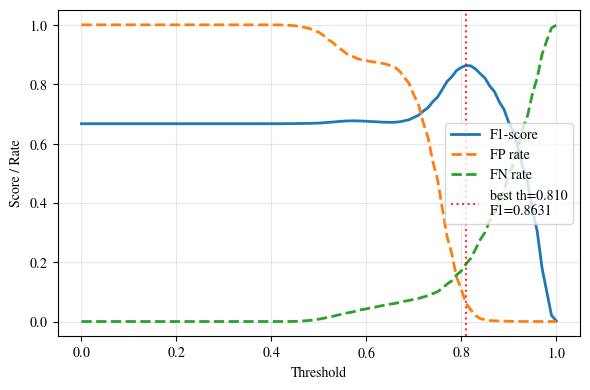

In [68]:
# 计算三条曲线
threshs, f1s, fps, fns = f1_fp_fn_curves(similars_swin, dissimilars_swin)

# 最佳 F1 点
best_idx = f1s.argmax()
best_t   = threshs[best_idx]

# 画图
plt.figure(figsize=(6, 4))
plt.plot(threshs, f1s, label='F1-score', lw=2)
plt.plot(threshs, fps, label='FP rate', lw=2, ls='--')
plt.plot(threshs, fns, label='FN rate', lw=2, ls='--')

# 最佳 F1 竖线
plt.axvline(x=best_t, color='r', ls=':', alpha=0.8,
            label=f'best th={best_t:.3f}\nF1={f1s[best_idx]:.4f}')

plt.xlabel('Threshold')
plt.ylabel('Score / Rate')
# plt.title('F1, FP rate, FN rate vs Threshold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 合并画图

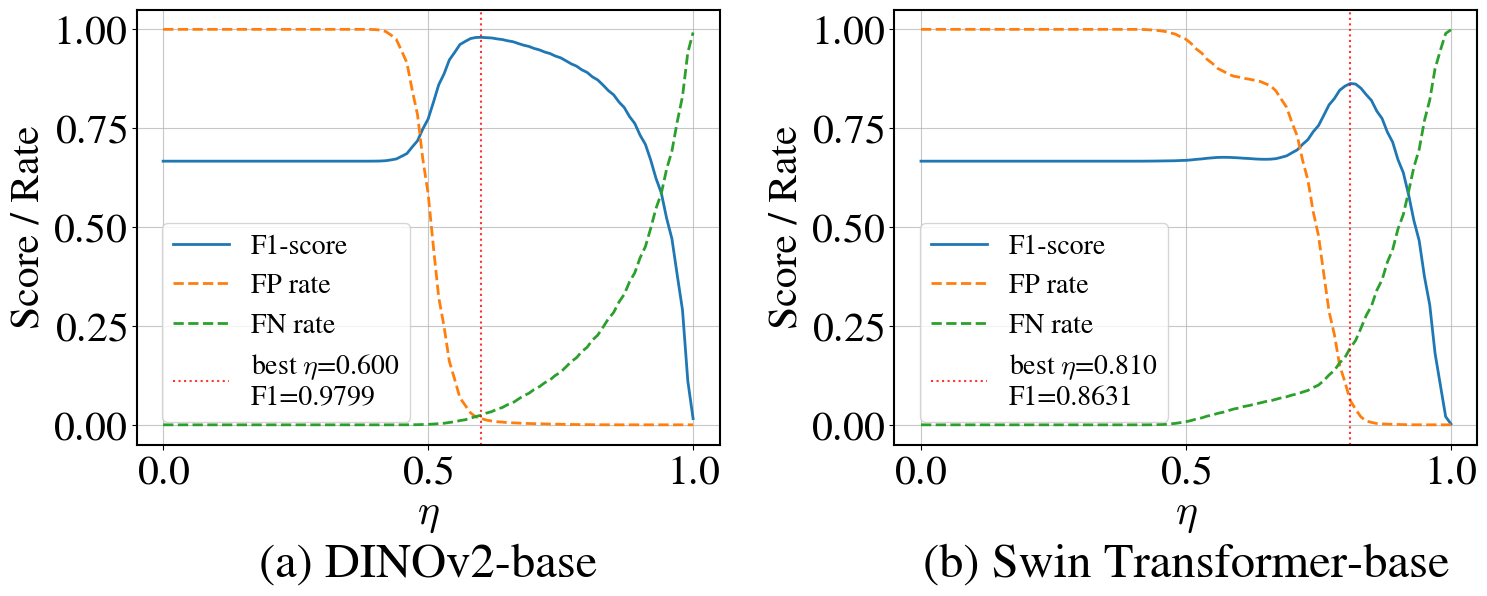

In [51]:
similars_list  = [similars_dino_v2, similars_swin]   # 长度=2 的 list，每个元素是一维 ndarray
dissimilars_list = [dissimilars_dino_v2, dissimilars_swin]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

model_names = ['DINOv2-base', 'Swin Transformer-base']

for idx, (sim, dis, name) in enumerate(zip(similars_list, dissimilars_list, model_names)):
    ax = axes[idx]

    # 计算三条曲线
    threshs, f1s, fps, fns = f1_fp_fn_curves(sim, dis)
    best_idx = f1s.argmax()
    best_t   = threshs[best_idx]

    # 画线
    ax.plot(threshs, f1s, label='F1-score', lw=2)
    ax.plot(threshs, fps, label='FP rate', lw=2, ls='--')
    ax.plot(threshs, fns, label='FN rate', lw=2, ls='--')
    ax.axvline(x=best_t, color='r', ls=':', alpha=0.8,
               label=f'best $\eta$={best_t:.3f}\nF1={f1s[best_idx]:.4f}')

    # 外观
    ax.set_xlabel('$\eta$', fontsize=30)
    ax.set_ylabel('Score / Rate', fontsize=30)
    ax.tick_params(axis='both', labelsize=30)
    ax.grid(True, linestyle='-', alpha=0.7)
    [sp.set_linewidth(1.5) for sp in ax.spines.values()]

    # 字母标题
    ax.set_title(f'({chr(97+idx)}) {name}', pad=15, y=-0.35, fontsize=35)

    # 图例（固定在左下）
    ax.legend(loc='lower left', bbox_to_anchor=(0.02, 0.02), fontsize=20)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25, wspace=0.3)
plt.savefig('./figs/F1 score.png', dpi=300, bbox_inches='tight')
plt.show()